## Imports

In [34]:
import re
from matplotlib import pyplot as plt

## Extracting actual text to work with

In [35]:
def selectFirstVersionForEachWord(paragraph: str) -> str:
    return re.sub(r'\((.*?)\|.*?\)', r'\1', paragraph)

def extractParagraphs(file) -> list[str]:
    paragraphs = []
    current_paragraph = ''
    
    for line in file:
        if line.strip().startswith("#") or len(line) < 2:
            continue

        last_character = line[-2]

        if last_character in ['-', '=']:
            current_paragraph += line[:-2]
        else:
            current_paragraph += line[:-1]

        if last_character == '=':
            paragraphs.append(selectFirstVersionForEachWord(current_paragraph.strip()))
            current_paragraph = ''

    return paragraphs



def extractWordsFromParagraphAndLower(paragraph: str) -> list[str]:
    return re.split(r'[\s,\.\[\]\{\}:;"]', paragraph.lower().replace('-', '').replace('_', ''))


# ------------------------------------------------------------------------- #

def readCodex(path: str) -> list[str]:
    with open(path, 'r') as f:
        return list(map(extractWordsFromParagraphAndLower, extractParagraphs(f)))


### Results - text after processing:

In [36]:
# for p in readCodex('FSG.txt'):
#     print(p)

## Counting N-Grams

In [37]:
def countNGrams(text: list[str], n: int) -> dict[str, int]:
    ngrams = {}

    for paragraph in text:
        for i in range(len(paragraph) - n + 1):
            ngram = ' '.join(paragraph[i:i+n])
            if ngram not in ngrams:
                ngrams[ngram] = 0
            ngrams[ngram] += 1

    return ngrams

In [38]:
def getSortedNGramsAndCalculateScores(ngrams: dict[str, int]) -> list[tuple[str, int]]:
    return list(map(lambda pair: (pair[1][0], pair[1][1], pair[0] / pair[1][1]), enumerate(sorted(ngrams.items(), key=lambda x: x[1], reverse=True))))

In [94]:
def filterGraphByRequiringMinimalDegreeAndCount(graph: dict[str, dict[str, int]], minimal_degree: int, minimal_count: int) -> dict[str, dict[str, int]]:
    return {k: v for k, v in graph.items() if len(v) >= minimal_degree and max(v.values()) >= minimal_count}

def getWordsGraphs(text: list[str]) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    graph_forward = {}
    graph_backward = {}

    for paragraph in text:
        for i in range(len(paragraph) - 1):
            word = paragraph[i]
            next_word = paragraph[i+1]

            if word not in graph_forward:
                graph_forward[word] = {next_word: 1}
            else:
                next_words = graph_forward[word]
                if next_word not in next_words:
                    next_words[next_word] = 1
                else:
                    next_words[next_word] += 1

            if next_word not in graph_backward:
                graph_backward[next_word] = {word: 1}
            else:
                previous_words = graph_backward[next_word]
                if word not in previous_words:
                    previous_words[word] = 1
                else:
                    previous_words[word] += 1

    return (graph_forward, graph_backward)

def getFilteredWordsGraph(text: list[str], minimal_degree: int, minimal_count: int) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    graph_forward, graph_backward = getWordsGraphs(text)
    filtered_graph_forward = filterGraphByRequiringMinimalDegreeAndCount(graph_forward, minimal_degree, minimal_count)
    filtered_graph_backward = filterGraphByRequiringMinimalDegreeAndCount(graph_backward, minimal_degree, minimal_count)

    all_words_preceding = set(filtered_graph_forward.keys())
    all_words_following = set(filtered_graph_backward.keys())

    return ({k: {word: count for word, count in v.items() if word in all_words_following} for k, v in filtered_graph_forward.items()},
            {k: {word: count for word, count in v.items() if word in all_words_preceding} for k, v in filtered_graph_backward.items()})

def drawBipartialGraph(graph: (dict[str, dict[str, int]], dict[str, dict[str, int]]), title: str, print_labels: bool = False):
    plt.figure(figsize=(30, 30))
    plt.title(title)
    plt.axis('off')

    graph_network_forward, graph_network_backward = graph

    max_degree_first_word = max(map(len, graph_network_forward.values()))
    max_degree_second_word = max(map(len, graph_network_backward.values()))

    max_count= max(map(max, map(lambda x: x.values(), graph_network_forward.values())))

    all_words = set(graph_network_forward.keys())
    for words in graph_network_forward.values():
        all_words.update(words.keys())

    all_words_list = list(all_words)
    all_words_list.sort()

    word_to_index = {word: i for i, word in enumerate(all_words_list)}

    for word, words in graph_network_forward.items():
        for next_word in words.keys():
            count = graph_network_forward[word][next_word]
            count_scaled = count / max_count

            degree_scaled_first_word = len(words) / max_degree_first_word
            degree_scaled_second_word = len(graph_network_backward[next_word]) / max_degree_second_word

            first_word_y = word_to_index[word]
            second_word_y = word_to_index[next_word]

            plt.plot([0, 1], [first_word_y, second_word_y],
                     color=(0, 0,
                            count_scaled, 1))
            
            if print_labels:
                plt.text(0, first_word_y, word, horizontalalignment='right')
                plt.text(1, second_word_y, next_word, horizontalalignment='left')

    plt.show()

In [40]:
print(list(sorted(countNGrams(readCodex('FSG.txt'), 3).items(), key=lambda x: x[1], reverse=True)))

[('scg 4odam tc8g', 4), ('tcg 4oe tc8g', 4), ('toe toe 8am', 3), ('4odc8g 4odc8g 4odc8g', 3), ('4oe tc8g 4odam', 3), ('sc8g 4odam scg', 3), ('oe sc8g 4odc8g', 3), ('sc8g 4odc8g 4odcc8g', 3), ('oe sc8g 4odccg', 3), ('tc8g 4odccg 4odccg', 3), ('toe tg tam', 2), ('toe toe toe', 2), ('hzor toe tor', 2), ('tam thzg hzo', 2), ('8am 4ohtg 4ohor', 2), ('tor toe 8am', 2), ('toe 8am tdam', 2), ('odc8g odc8g 4odc8g', 2), ('8am 8am o8g', 2), ('8ar ar ae', 2), ('tor tcdg toe', 2), ('or am to8g', 2), ('oe 2 am', 2), ('oham ohar tc8g', 2), ('sc8g 4odan 8ar', 2), ('sc8g 4odar sc8g', 2), ('4odam oe tc8g', 2), ('oe tc8g 4oe', 2), ('tc8g 4oe tc8g', 2), ('scc8g 4odc8g tc8g', 2), ('4odc8g tc8g tc8g', 2), ('8air tcg 4odam', 2), ('8ae t8g 8ae', 2), ('4odc8g 4odcc8g 4odc8g', 2), ('4oe sc8g oe', 2), ('sccg or or', 2), ('4oham tc8g 4odam', 2), ('tc8g 4odam tc8g', 2), ('tc8g 4odam sc8g', 2), ('sc8g 4odcc8g 4odc8g', 2), ('sc8g tc8g 4oe', 2), ('4odcc8g 4odccg ram', 2), ('sc8g 4odae tc8g', 2), ('4odae tc8g 4odc8g',

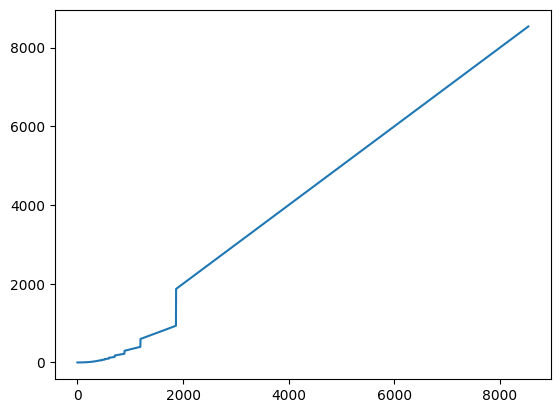

In [41]:
getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 1))

plt.plot(list(map(lambda x: x[2], getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 1)))))

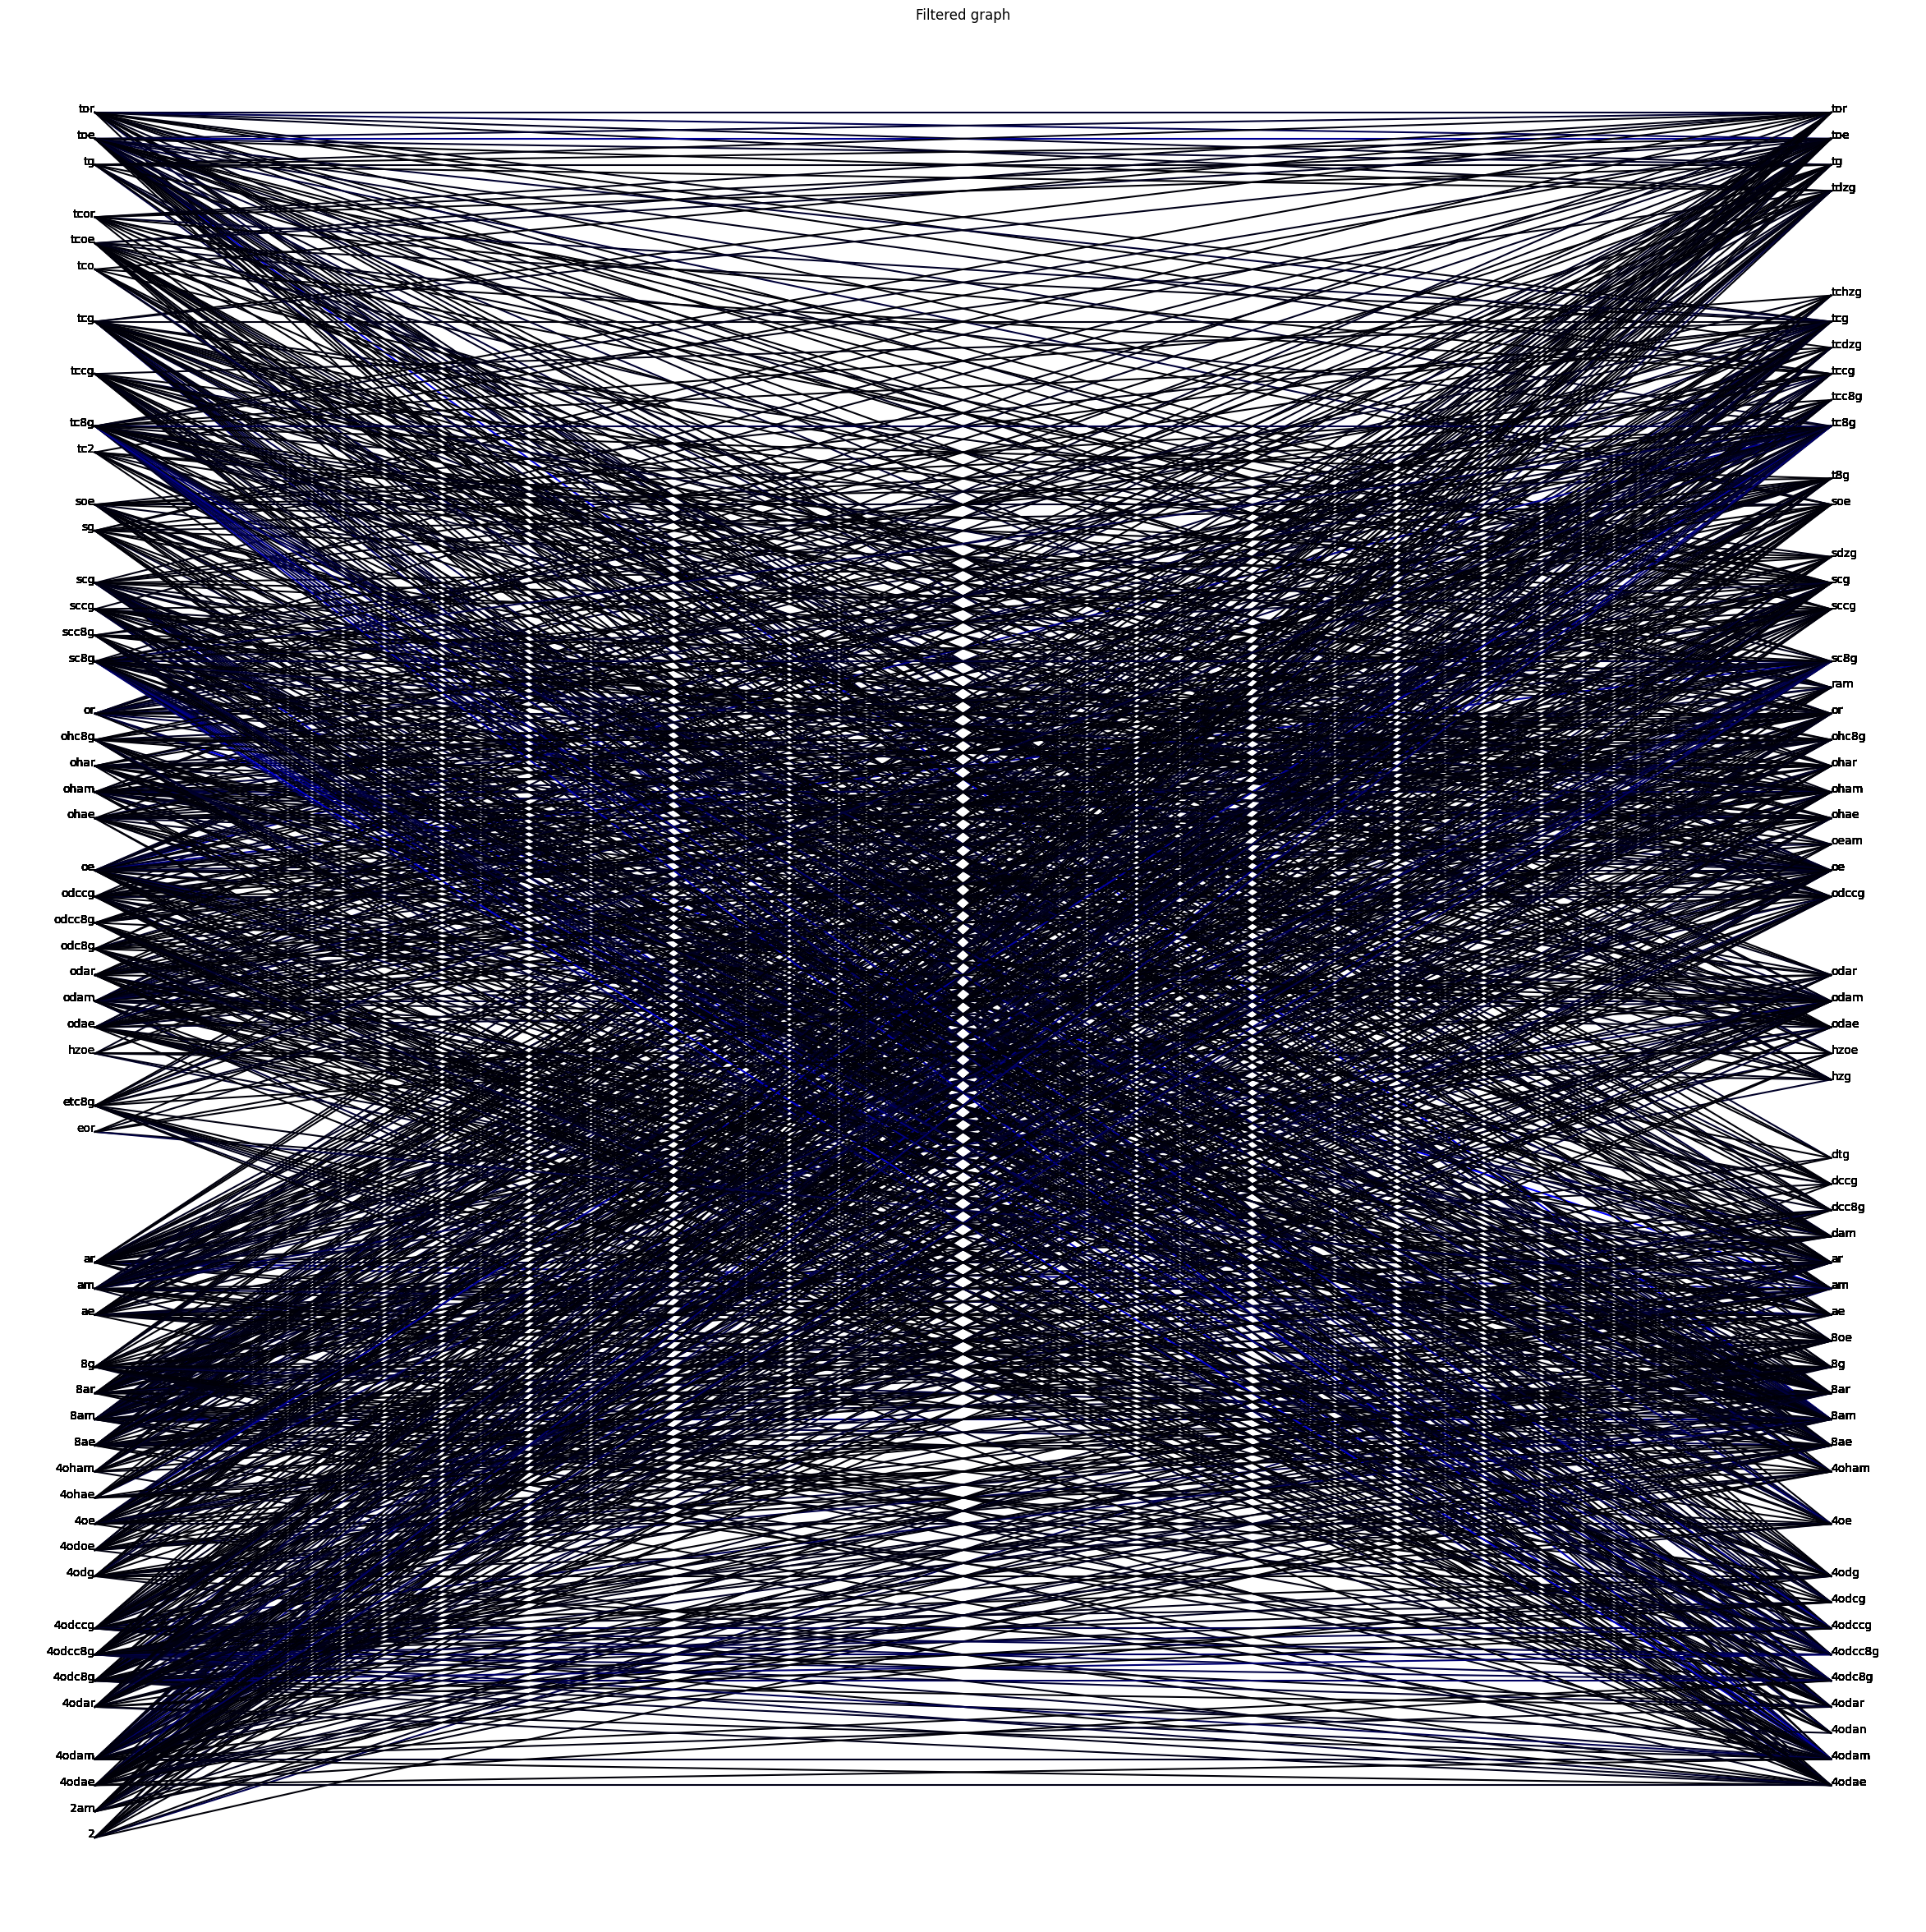

In [95]:
drawBipartialGraph(getFilteredWordsGraph(readCodex('FSG.txt'), 1, 5), 'Filtered graph', True)